In [1]:
#import required python classes and package
import numpy as np
import pandas as pd
import shap #loading SHAP tool for XAI based explanation
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from xgboost import XGBClassifier
from keras_dgl.layers import GraphCNN #loading GNN class
import keras.backend as K
from keras.regularizers import l2
from keras.utils.np_utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D
from keras.models import Sequential, load_model
import os
from keras.callbacks import ModelCheckpoint
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics 
import seaborn as sns

c:\users\yaruk\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\yaruk\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\yaruk\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\yaruk\appd

In [2]:
#load and display dataset values
dataset = pd.read_csv('Dataset/drug200.csv')
dataset

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


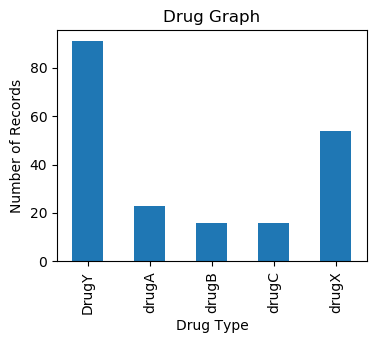

In [89]:
#visualize graph of different drug found in dataset
labels = np.unique(dataset['Drug'])
label = dataset.groupby('Drug').size()
label.plot(kind="bar", figsize=(4,3))
plt.xlabel('Drug Type')
plt.ylabel('Number of Records')
plt.xticks(rotation=90)
plt.title("Drug Graph")
plt.show()

In [90]:
#dataset processing like converting non-numeric data to numeric data
label_encoder = []
columns = dataset.columns
types = dataset.dtypes.values
for i in range(len(types)):
    name = types[i]
    if name == 'object': #finding column with object type
        le = LabelEncoder()
        dataset[columns[i]] = pd.Series(le.fit_transform(dataset[columns[i]].astype(str)))#encode all str columns to numeric
        label_encoder.append([columns[i], le])
dataset.fillna(0, inplace = True)
dataset

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,25.355,0
1,47,1,1,0,13.093,3
2,47,1,1,0,10.114,3
3,28,0,2,0,7.798,4
4,61,0,1,0,18.043,0
...,...,...,...,...,...,...
195,56,0,1,0,11.567,3
196,16,1,1,0,12.006,3
197,52,1,2,0,9.894,4
198,23,1,2,1,14.020,4


In [91]:
#dataset shuffling and splitting data into train and test
Y = dataset['Drug'].ravel()
dataset.drop(['Drug'], axis = 1,inplace=True)
X = dataset.values
indices = np.arange(X.shape[0])
np.random.shuffle(indices)#shuffling dataset values
X = X[indices]
Y = Y[indices]
scaler = StandardScaler()
X = scaler.fit_transform(X)#features normalization
#split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4)
print("Total records found in dataset = "+str(X.shape[0]))
print("Total features found in dataset= "+str(X.shape[1]))
print("80% dataset for training : "+str(X_train.shape[0]))
print("20% dataset for testing  : "+str(X_test.shape[0]))

Total records found in dataset = 200
Total features found in dataset= 5
80% dataset for training : 120
20% dataset for testing  : 80


In [92]:
#define global variables to save accuracy and other metrics
accuracy = []
precision = []
recall = []
fscore = []

In [93]:
#function to calculate all metrics
def calculateMetrics(algorithm, testY, predict):
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+" Accuracy  : "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FSCORE    : "+str(f))
    cm = metrics.confusion_matrix(testY,predict)
    plt.figure(figsize =(6, 3)) 
    ax = sns.heatmap(cm,xticklabels=labels,yticklabels=labels,annot=True,cmap="viridis",fmt="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()    

XGBoost Accuracy  : 95.0
XGBoost Precision : 93.90598290598291
XGBoost Recall    : 92.63305322128852
XGBoost FSCORE    : 92.84962299046808


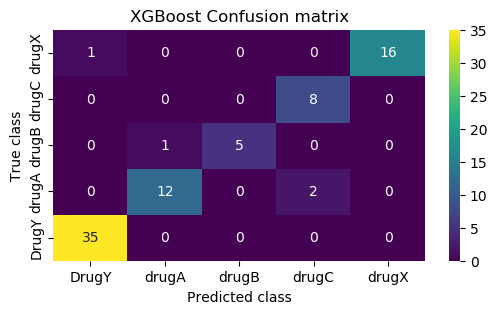

In [94]:
#training XGBOOST algorithm on 80% training data and then predicting on 20% test data
xgc = XGBClassifier(n_estimators=2)
xgc.fit(X_train, y_train)
#performing prediction on test data
predict = xgc.predict(X_test)
#calling function to calculate accuracy on predicted data
calculateMetrics("XGBoost", y_test, predict)

Graph Model Accuracy  : 93.75
Graph Model Precision : 89.71428571428571
Graph Model Recall    : 92.06162464985994
Graph Model FSCORE    : 90.44644244644245


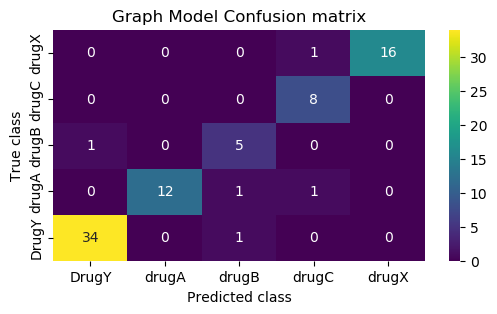

In [95]:
#training graphCNN algorithm
y_train1 = to_categorical(y_train)
y_test1 = to_categorical(y_test)
#Create GNN model to detect fault from all services
graph_conv_filters = np.eye(1)
graph_conv_filters = K.constant(graph_conv_filters)
graph_model = Sequential()
graph_model.add(GraphCNN(128, 1, graph_conv_filters, input_shape=(X_train.shape[1],), activation='elu', kernel_regularizer=l2(5e-4)))
graph_model.add(GraphCNN(64, 1, graph_conv_filters, input_shape=(X_train.shape[1],), activation='elu', kernel_regularizer=l2(5e-4)))
graph_model.add(GraphCNN(1, 1, graph_conv_filters, input_shape=(X_train.shape[1],), activation='elu', kernel_regularizer=l2(5e-4)))
graph_model.add(Dense(units = 256, activation = 'elu'))
graph_model.add(Dense(units = y_train1.shape[1], activation = 'softmax'))
graph_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/gcnn_weights.h5") == False:
    hist = graph_model.fit(X_train, y_train1, batch_size=1, epochs=50, validation_data = (X_test, y_test1), verbose=1)
    graph_model.save_weights("model/gcnn_weights.h5")
else:
    graph_model.load_weights("model/gcnn_weights.h5")
#perform prediction on test data of all services and calculate accuracy and other metrics
pred = []
for i in range(len(X_test)):
    temp = []
    temp.append(X_test[i])
    temp = np.asarray(temp)
    predict = graph_model.predict(temp, batch_size=1)
    predict = np.argmax(predict)
    pred.append(predict)
y_tested = np.argmax(y_test1, axis=1)    
predict = np.asarray(pred)
#calling function to calculate accuracy on predicted data
calculateMetrics("Graph Model", y_tested, predict)

Neural Network Accuracy  : 91.25
Neural Network Precision : 90.45751633986929
Neural Network Recall    : 86.84733893557424
Neural Network FSCORE    : 87.50524624565547


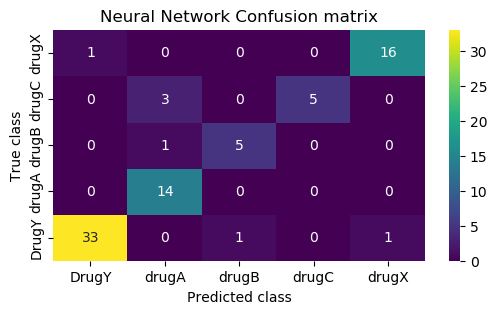

In [96]:
#training neural network algorithm
nn = MLPClassifier(max_iter=800)
nn.fit(X_train, y_train)
predict = nn.predict(X_test)
#calling function to calculate accuracy on predicted data
calculateMetrics("Neural Network", y_test, predict)

Extension CNN2D Accuracy  : 98.75
Extension CNN2D Precision : 99.44444444444444
Extension CNN2D Recall    : 98.82352941176471
Extension CNN2D FSCORE    : 99.11224925309433


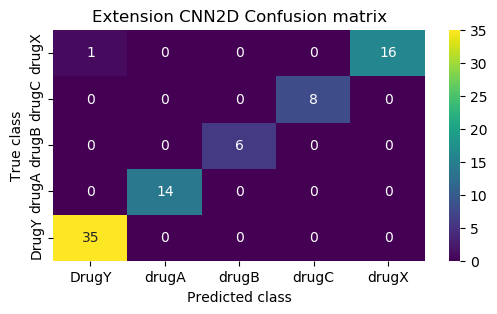

In [97]:
#training extension Convolution Neural Network 2D algortihm as extension
X_train1 = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1, 1))
X_test1 = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1, 1))
cnn_model = Sequential()
#creating cnn2d layer with 32 neurons of 1 X 1 matrix to filter dataset 32 times
cnn_model.add(Convolution2D(32, (1, 1), input_shape = (X_train1.shape[1], X_train1.shape[2], X_train1.shape[3]), activation = 'relu'))
#max layer tio collect relevant filtered features from CNN layer
cnn_model.add(MaxPooling2D(pool_size = (1, 1)))
cnn_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (1, 1)))
#defining output layer
cnn_model.add(Flatten())
cnn_model.add(Dense(units = 256, activation = 'relu'))
cnn_model.add(Dense(units = y_train1.shape[1], activation = 'softmax'))
#compiling the model
cnn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#training and loading model
if os.path.exists("model/cnn_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/cnn_weights.hdf5', verbose = 1, save_best_only = True)
    hist = cnn_model.fit(X_train1, y_train1, batch_size = 8, epochs = 50, validation_data=(X_test1, y_test1), callbacks=[model_check_point], verbose=1)
    f = open('model/cnn_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    cnn_model.load_weights("model/cnn_weights.hdf5")
#performing prediction on test data   
predict = cnn_model.predict(X_test1)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test1, axis=1)
#calling function to calculate accuracy on predicted data
calculateMetrics("Extension CNN2D", y_test1, predict)

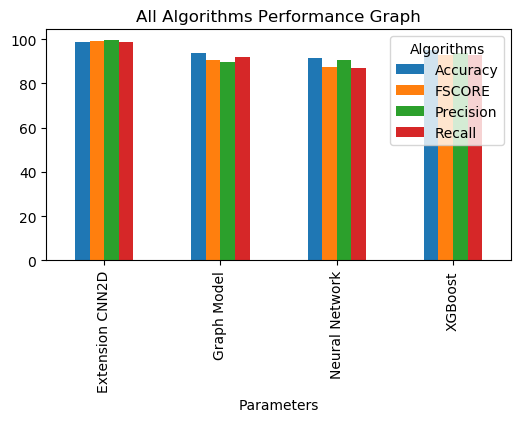

In [98]:
#comparison graph between all algorithms
df = pd.DataFrame([['XGBoost','Accuracy',accuracy[0]],['XGBoost','Precision',precision[0]],['XGBoost','Recall',recall[0]],['XGBoost','FSCORE',fscore[0]],
                   ['Graph Model','Accuracy',accuracy[1]],['Graph Model','Precision',precision[1]],['Graph Model','Recall',recall[1]],['Graph Model','FSCORE',fscore[1]],
                   ['Neural Network','Accuracy',accuracy[2]],['Neural Network','Precision',precision[2]],['Neural Network','Recall',recall[2]],['Neural Network','FSCORE',fscore[2]],
                   ['Extension CNN2D','Accuracy',accuracy[3]],['Extension CNN2D','Precision',precision[3]],['Extension CNN2D','Recall',recall[3]],['Extension CNN2D','FSCORE',fscore[3]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar', figsize=(6, 3))
plt.title("All Algorithms Performance Graph")
plt.show()

In [99]:
#now explain model prediction using features impact and shap tool
#here we are uisng force plot explanation to explain about features which is contributing most for the model to make
#correct prediction
shap.initjs()
explainer = shap.TreeExplainer(xgc, X_train)
# Explain the predictions of your model
shap_values = explainer.shap_values(X_train)
# Plot the SHAP values
shap.plots.force(explainer.expected_value[0], shap_values[0], feature_names=['Age','Sex','BP','Cholesterol','Na_to_K'])

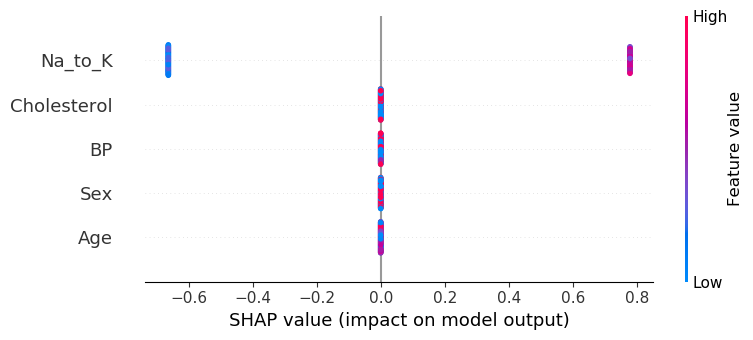

In [100]:
#summarry plot to explain names of features which is contributing most for the algorithm to make correct prediction
shap.summary_plot(shap_values[0], X_train, feature_names=['Age','Sex','BP','Cholesterol','Na_to_K'])

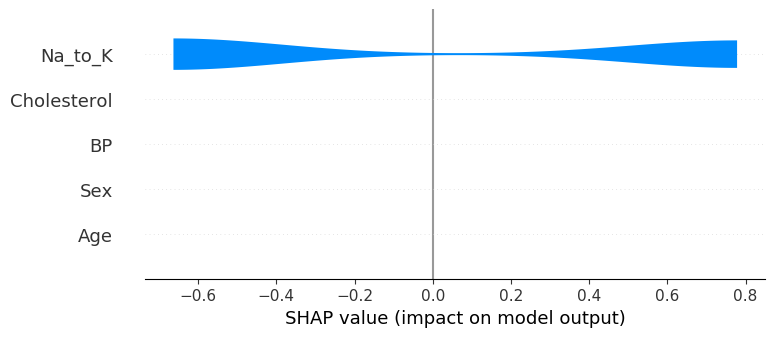

In [101]:
#violin plot to explain names of features which is contributing most for the algorithm to make correct prediction
shap.plots.violin(shap_values[0], feature_names=['Age','Sex','BP','Cholesterol','Na_to_K'])

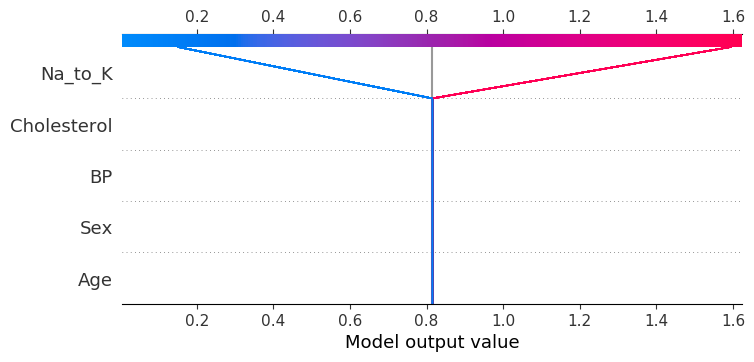

In [102]:
#decision plot to explain names of features which is contributing most for the algorithm to make correct prediction
shap.decision_plot(explainer.expected_value[0], shap_values[0], feature_names=['Age','Sex','BP','Cholesterol','Na_to_K'])

In [110]:
#predict drug based on patient condition
testData = pd.read_csv("Dataset/testData.csv")#load test data
temps = testData.values
for i in range(len(label_encoder)-1):
    temp = label_encoder[i]
    name = temp[0]
    le = temp[1]
    testData[name] = pd.Series(le.transform(testData[name].astype(str)))#encode all str columns to numeric
testData.fillna(0, inplace = True)#replace missing values
testData = testData.values
X = scaler.transform(testData)#normalize test data
X = np.reshape(X, (X.shape[0], X.shape[1], 1, 1))#reshape test data as cnn2d format
predict = cnn_model.predict(X)#predict on test data and then display predicted drug
for i in range(len(predict)):
    print("Test Data = "+str(temps[i])+" Predicted Drug = "+labels[np.argmax(predict[i])])
    print()

Test Data = [66 'F' 'NORMAL' 'NORMAL' 8.107] Predicted Drug = drugX

Test Data = [37 'F' 'HIGH' 'HIGH' 13.091] Predicted Drug = drugA

Test Data = [68 'M' 'LOW' 'HIGH' 10.291] Predicted Drug = drugC

Test Data = [23 'M' 'NORMAL' 'HIGH' 31.686] Predicted Drug = DrugY

Test Data = [24 'F' 'HIGH' 'NORMAL' 18.457] Predicted Drug = DrugY

Test Data = [68 'F' 'HIGH' 'NORMAL' 10.189] Predicted Drug = drugB

Test Data = [26 'F' 'LOW' 'HIGH' 14.16] Predicted Drug = drugC

